In [1]:
#First import a few common modules
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

In [4]:
# Using keras dictionary structure lets look at the arrays describing the instance data and the
# target data
# Note: Book uses sklearn to load data, but I could not get it to work so I use tensor flow. It is easier and
# involves less steps

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

In [6]:
# Apparently there are 70,000 images with 784 features. This is because each image is a 28 x 28 = 784 pixel.
# Let's look at the first target value
y_train[0]

5

In [7]:
# The first taret value is a 5. Since the label is a string and most ML expect numbers lets make y an interager
# Note: this step is only necessary if we use sklearn to load data
y = y.astype(np.uint8)

NameError: name 'y' is not defined

Saving figure some_digit_plot


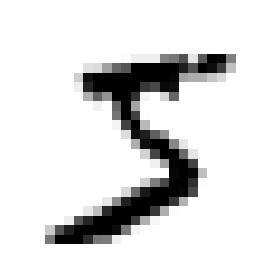

In [8]:
#Let's look @ the 1st digit to make sure they match
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X_train[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

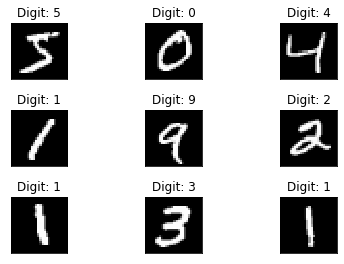

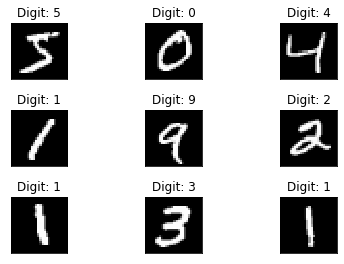

In [70]:
#Let's look @ the other digits to make sure they match
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Binary Classifier

In [71]:
# Let's start with a simple code that trains a binary classifier to identify one digit, 5.
# Since it is binary it will distinguish between 5 and not-5.

#First create the target vector for the classification task
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [75]:
# Note: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as 
# max_iter and tol. To be future-proof, we explicitly set these hyperparameters to their future default values.
# For simplicity, this is not shown in the book.


(60000,)

In [76]:
# Let's start with a Stochastic Gradient Decent (SGD) classifier. This efficiently handels large data sets by 
# training instances independently, one at a time.

# Before doing this we must reshape the X_train since it is an array with 3 dimensions (60000, 28, 28), but
# y_train_5 is a 2 dimension array (60000,)

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')



In [77]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [79]:
# check to make sure it is predicting properly using a known instance of 5
some_digit = X_train[0]
sgd_clf.predict([some_digit])

array([ True])

In [80]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Here cv = 3 means we are splitting the k-fold cross validaiton into 3 folds

array([0.95035, 0.96035, 0.9604 ])

In [81]:
# Let's test to see if we really have 95% accuracy, or if we are overfitting

#Let's make a classifier that classifies every image as "not-5"
from sklearn.base import BaseEstimator

# This class guesses "not-5"
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [82]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [84]:
# Since less than 10% of data is a 5, guessing "not-5" gets you over 90% accuracy
# We need a better way of determining accuracy. Try a confusion matrix

In [85]:
# Using cross-predict instead of cross-validation. This allows us to still test witout using the testing set. 
# It returns predictions made by each test fold instead of returing the evaluation scores

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [86]:
#Look @ the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [87]:
# Each row represents an "actual class" while each column represents a "predcted class"
# The first row consideres "non-5" images (negative class) 53,892 were true-negatives and 687 were 
# classified as 5's meaning false-positives.
# The second row considers the images of 5's (positive class). 1891 false negatives from classifying as 
# "non-5", and 3530 were consideres ture positives for correctly classifying as 5

In [98]:
#Next let's look @ precision (accuracy of positive prediction) = TP / (TP + FP), and the 
# recall = TP / (TP + FN)
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [93]:
#check that this is the same as what would be produced by precision equation
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [99]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [97]:
# Check that this is the same as what would be produced by recall equation
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [100]:
# The precision says that when it says the image is a 5, it is right only 83.7% of the time. The recall says
# that the algorithm only detects 65% of all the fives.

In [102]:
# Look @ F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [103]:
# To understand trade-off of precision/recall let's look @ how SGD makes classification decisions based on a 
# "decision threshold"
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [105]:
threshold = 0
y_some_digit_pred = (y_score > threshold) #check to see if threhold is 0
y_some_digit_pred

array([ True])

In [106]:
# It returns true since the the SGD Classifier uses a threshold equal to 0. Thus this code returns the same 
# predict() method

threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [108]:
# Returns false since raising the threshold decreases recall. It detects the five @ a threshold of 0, but
# misses @ a threshold of 80000

# First, use cross_val_predict function to get cores of all instances in the training set, specifying that 
# you want the decision scores.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

## ROC Curves

In [109]:
# One can use the precision_recall_curve() to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

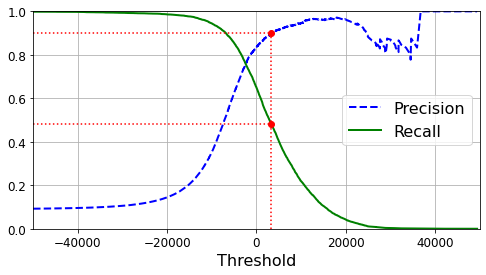

In [117]:
# plotting preceision and recall as a function of threshold using Matplitlib
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # used to create red dottel line for prec. = 0.9
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                
plt.show()

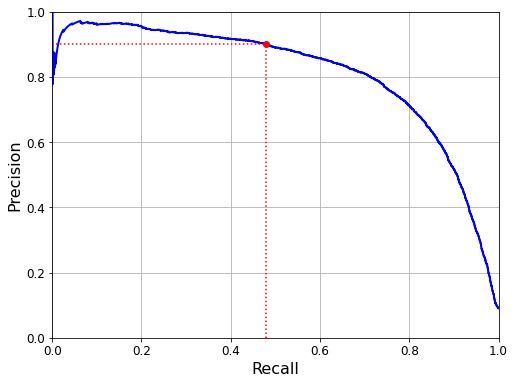

In [119]:
# One can also look @ precision vs recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

In [120]:
# Let's assume we want a threshold that gives 90% precision. Can find that value using...
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [121]:
threshold_90_precision

3370.0194991439557

In [122]:
#Now check the precision and recall using this value for predictions
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [123]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [124]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [125]:
# Next let's look @ a ROC curve (TPR vs FPR) = TP/(TP+FN) vs FP/(TN+FP)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


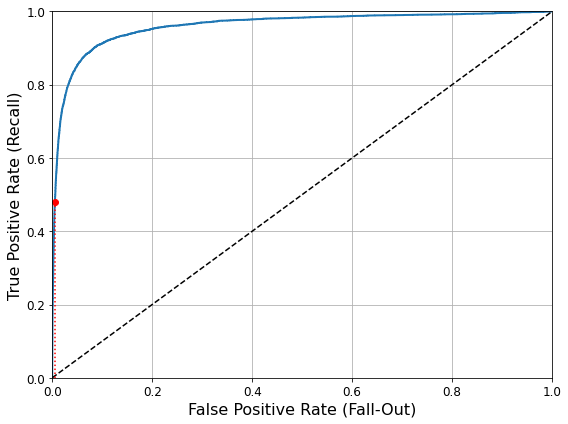

In [126]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal of purely random classifier
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))        
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   #highlights chosen ration for prec = 90%
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")              
                                  
plt.show()

In [127]:
# Measuring Area Under the Curve (AUC) is a way of testing the accuracy of different classifiers. This is 
# useful since AUC is scale and classifier invariant. A perfect classifier has has ROC AUC = 1 and a purely
# random has an AUC = 0.5 (as shown in dotted line above)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [128]:
# Here we should use the PR curve since our positive class is rare (5s) compared to the negatives (not-5)
# This is why ROC AUC is close to one even though th ePR curve should be closer to the top left corner

# now let's look at a random forest 
# 
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [129]:
# Instead of scores we will give the ROC function probabilities 
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


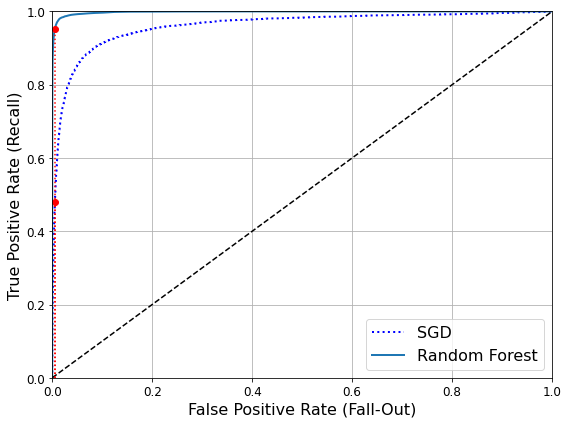

In [130]:
# Plot forst ROC along SGD ROC to compare preformance
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [131]:

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [132]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [133]:
recall_score(y_train_5, y_train_pred_forest)
# These metrics along with the ROC curve show the random forest preforms very well!

0.8662608374838591

## Multiclass Classification

In [135]:
# So far we have used a binary classifier (5 or not-5). Next let's look @ a Multiclass Classification. 
# This can be done by using multiclass classfiers (SDG, Random Forest, etc.) or by combining binary classfiers
# (Logistic Regression or SVM)

# Let's try a SVM classifier
from sklearn.svm import SVC


from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42) #declare classifier
svm_clf.fit(X_train[:1000], y_train[:1000]) #trains using original target class of 0-9
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [136]:
# This method uses the one-versus-one (OvO) strategy. This can be seen by decision _function shows 10 
# scores per instance instead of just 1.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [137]:
# It can be seen that 9.29 is the highest score. By counting you can see this is 5, as expected. 
# Can also check which class the highest score corresponds to with the following.

np.argmax(some_digit_scores)

5

In [138]:
# Can look at all target classes using
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [139]:
# Can check which class is stored in a given array index using
svm_clf.classes_[5]

5

In [140]:
# We can also force Scikit-Learn to use OvO or one-verse-the-rest (OvR). Let's now do OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [141]:
# Check that the length of classifier is only 10 since we used OvR
len(ovr_clf.estimators_)

10

In [142]:
some_digit_scores = ovr_clf.decision_function([some_digit])
some_digit_scores

array([[-0.9990256 , -0.99963766, -0.99949709, -0.99902667, -0.99986906,
         0.10132159, -0.99976287, -0.99933311, -0.99943631, -0.99924045]])

In [144]:
np.argmax(some_digit_scores)

5

In [146]:
# Now let's train the SGD classifier, a true mutliclass classifier

sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [149]:
# Look @ scores assigned to each classsifer
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [150]:
# This classifier is confident that it is a three
# Use cross-validatin to evaluate the classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [151]:
# Check that simply scaling (normalizing) the inputs increases the accuracy greatly
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) #Normalized the input (pixels)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [152]:
# ERROR ANALYSIS
# Assuming we have a promising model let's analyze the types of errors our model is making
# Fist look at a confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) # get predictions
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [153]:
# One can see that the numbers along the diagonals (meaning correct classification) are the largest. An easier
# way to look at this is an image representatino of the Confusion matrix

# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

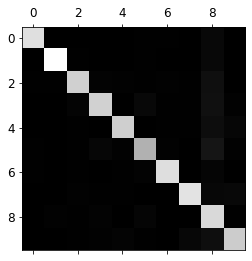

In [155]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

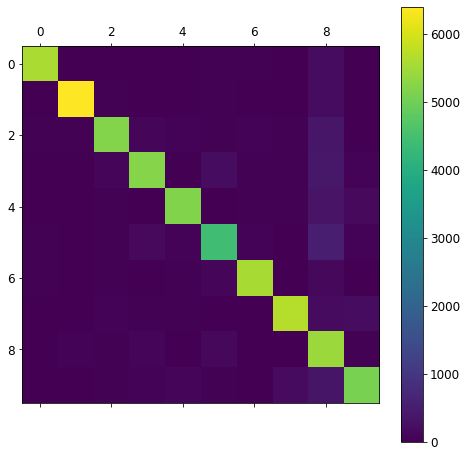

In [156]:
#or in color
plot_confusion_matrix(conf_mx)

## Error Analysis

In [157]:
# Note five is darker (bluer) than the rest. This could mean that there are fewer images of 5s in the dataset,
# or the clasifier does not perform well on 5s

# Let's look at errors. To compare error rates we need to divide each value in the confusion matrix by the 
# number of images in the corresponding class.

row_sums = conf_mx.sum(axis=1, keepdims=True) #gets number of images in corresponding class
norm_conf_mx = conf_mx / row_sums # normalized conf. matrix

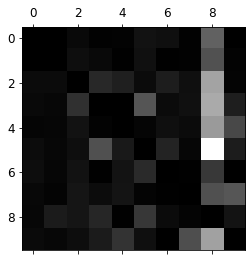

In [158]:
np.fill_diagonal(norm_conf_mx, 0) #fills diagonals with zero to keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

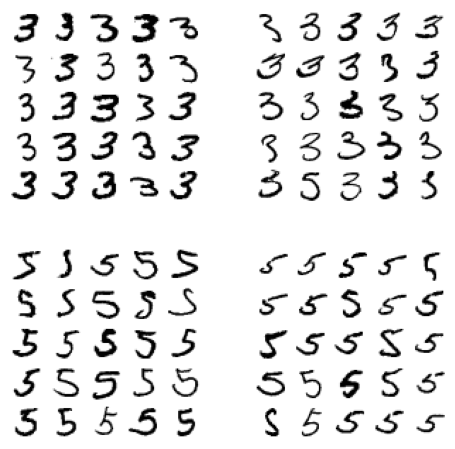

In [159]:
# Above the rows represent actual classes &and the columns represent predicted classes
# For example the column 8 is rather bright meaning there were quite a few images misclassified as 8s, but the
# row 8 is dark meaning most 8s were classified correctly
# This plot suggests we should focus our efforts on reducing false 8s (and the three-five misclassification)

# next let's lok at some individual errors, the ones where threes and fives were misclassified
# Left two 5 x 5 blocks show objects classified as 3s and the right two blocks show objects classified as fives

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

In [160]:
# Some are badly written resulting in misclasification, but some seem like more obvious errors. This is due
# to using a linear SGD classifer. One could try preprocessing images to make sure they are more centered
# and not too rotated.

# Multilabel Classification

In [161]:
# Here we look at k-nearest neightbor multilable classifier
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #indicates whether it is a 7, 8, or 9
y_train_odd = (y_train % 2 == 1) #checks if it is odd
y_multilabel = np.c_[y_train_large, y_train_odd] # creates array containing two labels for each digit

knn_clf = KNeighborsClassifier() # creates k-nearest neighbor classifier
knn_clf.fit(X_train, y_multilabel) # train K-NN on our two target arrays

KNeighborsClassifier()

In [162]:
# Make predictions (note: the two ouputs from two target arrays)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# One way to select right metric for a multilabel classifier is to use a F1 score for each label, then
# compute the average. This is done in the following code 

#This code was not ran since it could take hours depending on hardware
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # could als set average = "weighted" to weight label according to the number of instances

## Multioutput Classification

In [163]:
# Multioutput classsifcation allows for two possible values of a prediction
# To illustrate we build a system that removes noise from images. It is multioutput since there is one 
# label per pixel and each pixel can have multiple values

noise = np.random.randint(0, 100, (len(X_train), 784)) #adds noise using numpy random function
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

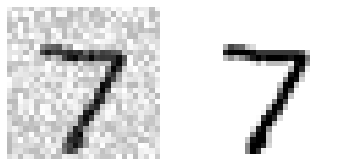

In [164]:
# Lets look at the noise we hav added by comparing noise (left) to non noise (right)
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

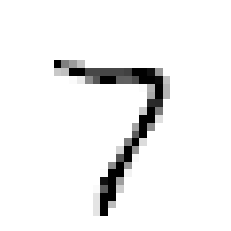

In [165]:
# Next let's train the classifier to clean this image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercies

## Question 1: 
Try to create a classifier for the MNIST data set with over 97% accuracy. Hint: K-NN is a good one to try, but you need to adjust the hyperparameters (use a grid search on weights & n_neighbors hyperparameters)

In [166]:
# Warning: this could take up to 16hrs 
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=  43.7s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=  46.0s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=  44.2s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  57.5s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  54.9s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=  57.4s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=  54.5s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=  49.2s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=  57.5s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=  49.6s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  52.2s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [167]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [168]:
grid_search.best_score_

0.9716166666666666

In [169]:
# Check accuracy with the test set
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Question 2: Data Augmentation
Write a function that can shift a MNIST image in any direction by one pixel. Then, for each image in the training set, create four shifted copies (one per direciton) and add them to the training set. Finally, triain your best model on this expanded training set and measure it's accuracy. This is called data augmentation and should improve the performance of the model. 

In [170]:
from scipy.ndimage.interpolation import shift #used to "shift" data around

In [171]:
def shift_image(image, dx, dy): #create class to shift image in x & y direction by dx & dy amount
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

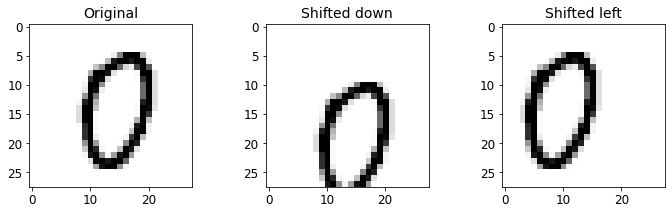

In [172]:
# test by shifting an image down and to the left by five pixel and then looking at the augmented images 
# compared to the original

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [173]:
# Now lets augment the images by one pixel.
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)): # moves up, down, left, right by one pixel
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented) # puts augmented images in a numpy array
y_train_augmented = np.array(y_train_augmented)

In [174]:
# shuffle the training data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [175]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_) #use best parameters from previous search in Question 1

In [176]:
knn_clf.fit(X_train_augmented, y_train_augmented) #train classifier

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [177]:
#test new augmented model. Warnging: could take an hour to run depending on hardware. Mine is fast thanks to
# SSD card
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got a 0.5% accuracy boost.

## Question 3: Tackle the Titanic dataset
The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to Kaggle and go to the Titanic challenge to download train.csv and test.csv. Save them to the datasets/titanic directory.

In [178]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [179]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [180]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [181]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.

Pclass: passenger class.

Name, Sex, Age: self-explanatory

SibSp: how many siblings & spouses of the passenger aboard the Titanic.

Parch: how many children & parents of the passenger aboard the Titanic.

Ticket: ticket id

Fare: price paid (in pounds)

Cabin: passenger's cabin number

Embarked: where the passenger embarked the Titanic

Let's get more info to see how much data is missing...

In [182]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, but is probably an important attribute. We will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

In [183]:
# The following code looks @ the numerical attributes of data
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% Survived. 
The mean Fare was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
The mean Age was less than 30 years old.

In [184]:
# The following code looks at the "Survived" category to make sure it is either a 0 or 1
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Take a look @ all categorical attributes to see what the attributes they have

In [185]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [186]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [187]:
train_data["Embarked"].value_counts() # Passengers embarked from C=Cherbourg, Q=Queenstown, or S=Southampton.

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Now let's build our preprocessing pipelines. We will reuse the DataframeSelector we built in the previous chapter to select specific attributes from the DataFrame. The code below uses a mix of Pipeline, FeatureUnion and a custom DataFrameSelector to preprocess some columns differently. Since Scikit-Learn 0.20, it is preferable to use a ColumnTransformer

In [191]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): #Gets attribute names
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [192]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [193]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the regular SimpleImputer does not work on those)

In [194]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [195]:
from sklearn.preprocessing import OneHotEncoder


Now we can build the pipeline for the categorical attributes

In [196]:
#Convert data to numeric
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)), 
    ])

In [197]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [198]:
# Combine the numerical and categorical data

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want

In [199]:
# Splitting training data into label and instances
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [200]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an SVC

In [201]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [202]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. Now let's use cross-validation to have an idea of how good our model is?

In [203]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

About 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the leaderboard for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Let's try to build a model that reaches 80% accuracy.

Let's try a RandomForestClassifier

In [204]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the boxplot() function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$

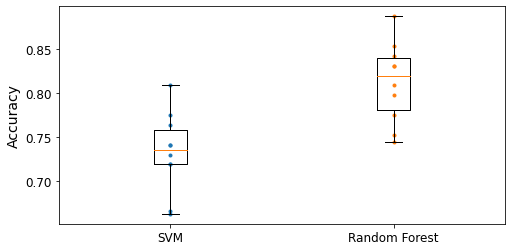

In [205]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:

1. Compare many more models and tune hyperparameters using cross validation and grid search,
2. Do more feature engineering, for example: replace SibSp and Parch with their sum, try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely),
3. try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [206]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [207]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Question 4: Spam Filter

In [9]:
import os
import tarfile # allows tarfile access
import urllib.request # Library for opening URLs

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [10]:
# Get SPAM data from path
fetch_spam_data()

In [15]:
# Load the emails
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20] # > 20 ensures legit files
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20] 

In [16]:
len(ham_filenames)

2500

In [17]:
len(spam_filenames)

500

In [19]:
print(ham_filenames)

['00001.7c53336b37003a9286aba55d2945844c', '00002.9c4069e25e1ef370c078db7ee85ff9ac', '00003.860e3c3cee1b42ead714c5c874fe25f7', '00004.864220c5b6930b209cc287c361c99af1', '00005.bf27cdeaf0b8c4647ecd61b1d09da613', '00006.253ea2f9a9cc36fa0b1129b04b806608', '00007.37a8af848caae585af4fe35779656d55', '00008.5891548d921601906337dcf1ed8543cb', '00009.371eca25b0169ce5cb4f71d3e07b9e2d', '00010.145d22c053c1a0c410242e46c01635b3', '00011.fbcde1b4833bdbaaf0ced723edd6e355', '00012.48a387bc38d1316a6f6b49e8c2e43a03', '00013.81c34741dbed59c6dde50777e27e7ea3', '00014.cb20e10b2bfcb8210a1c310798532a57', '00015.4d7026347ba7478c9db04c70913e68fd', '00016.ef397cef16f8041242e3b6560e168053', '00017.08ef2d89f14cf7e2a458b80697eb1837', '00018.6fee38026193b5adde4b56892a6f14bc', '00019.5322cb10d8819b39499924d852819c27', '00020.d10651e31fcb92630c6229ec773cfe26', '00021.607c41268c5b0d66e81b58713a66d12c', '00022.48098f942c31097d2ef605df44dd8593', '00023.e0e815ea1d7fd40e7e70b4c0035bef0c', '00024.59c2cb781c60594315241e2b50

In [20]:
# We can use Python's email module to parse these emails (this handles headers, encoding, and so on)
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [21]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [24]:
# Let's look at one example of ham and one example of spam, to get a feel of what the data looks like
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [25]:
print(spam_emails[1].get_content().strip())

1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama













If you wish to leave this list please use the link below.
http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie


Some emails are actually multipart, with images and attachments. Let's look at the various types of structures the emails have. First create a function that will get the email strucuter, then create a function that will count the emails with various types of structure

In [26]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [27]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [28]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [29]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

There are a lot of structural differences between SPAM and HAM. For one, SPAM has a lot of html, but has no pgp-signature.

In [32]:
# Look @ header of emails
for header, value in spam_emails[0].items():
    print(header , ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [33]:
for header, value in ham_emails[0].items():
    print(header, ":", value)

Return-Path : <exmh-workers-admin@spamassassin.taint.org>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from phobos [127.0.0.1]	by localhost with IMAP (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received : from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received : from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002    07:35:02 -0400 (EDT)
Delivered-To : exmh-workers@listman.spamassassin.taint.org
Received : from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org 

Clearly there is less info inthe SPAM. Certainly there is other useful information here. One can also look at individual headers.

In [35]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [36]:
# Split data into training and testing set

import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails)) #makes a target of 0 for HAM and 1 for SPAM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great BeautifulSoup library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions. The following function first drops the "head" section, then converts all "a" tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as "&gt"; or "&nbsp"):

In [37]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [38]:
# test to see if html -> plain text worked
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [41]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [42]:
# It works! Now let's write a function that takes an email as input and returns its content as plain text, 
# whatever its format is:

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [43]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Let's throw in some stemming. Stemming is the process of reducing inflected words to their word stem, base or root form For this to work, you need to install the Natural Language Toolkit (NLTK). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the --user option):

pip3 install nltk

In [44]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core regular expressions but we will just use the urlextract library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the --user option):

pip3 install urlextract

In [46]:
# if running this notebook on Colab, we just pip install urlextract
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [47]:
try:
    import urlextract 
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's split() method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [49]:
# Test transform on some emails
X_few = X_train[:3] # makes array for first three emails
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

This looks correct.
Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose fit() method will build the vocabulary (an ordered list of the most common words) and whose transform() method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [50]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [51]:
#Apply to our small set of emails for testing
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [52]:
# Look @ vocabulary
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

Everything looks good. 
Let's transform the entire dataset and train our classifier

In [54]:
from sklearn.pipeline import Pipeline

# pipeline for creating eamail -> wordcounter -> vector
preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [55]:
# Train on linera regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.981) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.985) total time=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] END ................................ score: (test=0.991) total time=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


0.9858333333333333

Over 98.5%, not bad for a first try! However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [56]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%
